In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

In [2]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
import os
def test_hog_features(img_dir, img_name):
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    img = mpimg.imread(os.path.join(img_dir, img_name))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray, cmap='gray')
    
    plt.subplot(1, 2, 2)
    features, hog_img = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    plt.imshow(hog_img, cmap='gray')

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


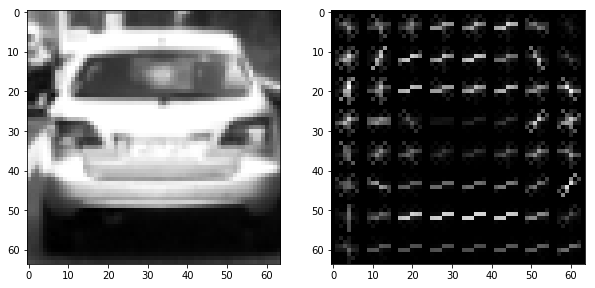

In [4]:
test_hog_features('./vehicles/KITTI_extracted', '31.png')

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
def extract_img_features(img_name, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    img = mpimg.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)  # png file has value between 0 and 1
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
        
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
    if hog_channel == -1:
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                        orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    features = np.concatenate((hist_features, spatial_features, hog_features))
        
    return features

In [8]:
def extract_features(img_list, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    features_ary = []
    for img_name in img_list:
        features = extract_img_features(img_name, cspace, spatial_size, hist_bins, hist_range,
                                       hog_channel, orient, pix_per_cell, cell_per_block)
        features_ary.append(features)
    return features_ary

In [9]:
import glob
def read_data(data_dir):
    data = []
    for dir, _ ,_ in os.walk(data_dir):
        data.extend(glob.glob(os.path.join(dir,'*.*')))
    return data

In [10]:
car_list = read_data('./vehicles')
nocar_list = read_data('./non-vehicles')
print(len(car_list), len(nocar_list))

8792 8968


In [11]:
features_extract_parameters = [['YCrCb', 'YUV', 'HLS', 'LUV', 'HSV', 'RGB'], [-1, 0, 1, 2]]

In [12]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

class Model():
    def __init__(self, features_parameter):
        self.cspace = features_parameter[0]
        self.hog_channel = features_parameter[1]
        self.clf = LinearSVC(C=1, random_state=0)
        self.scaler = StandardScaler()
        self.spatial_size = (16, 16)
        self.hist_bins = 16
        self.hist_range = (0, 256)
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.beta = 0.5
    
    def scale_features(self, car_list, nocar_list):
        car_features = extract_features(car_list, self.cspace, self.spatial_size, self.hist_bins, self.hist_range,
                                        self.hog_channel, self.orient, self.pix_per_cell, self.cell_per_block)
        nocar_features = extract_features(nocar_list, self.cspace, self.spatial_size, self.hist_bins, self.hist_range,
                                          self.hog_channel, self.orient, self.pix_per_cell, self.cell_per_block)
        features = np.vstack([car_features, nocar_features]).astype(np.float64)
        self.scaler.fit(features)
        X = self.scaler.transform(features)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))
        return X, y
    
    def fit(self, car_list, nocar_list):
        X, y = self.scale_features(car_list, nocar_list)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
        self.clf.fit(X_train, y_train)
    
        y_train_pred = self.clf.predict(X_train)
        y_test_pred = self.clf.predict(X_test)
    
        accuracy_train =  accuracy_score(y_train, y_train_pred)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        f_train = fbeta_score(y_train, y_train_pred, beta=self.beta)
        f_test = fbeta_score(y_test, y_test_pred, beta=self.beta)
        
        return accuracy_train, accuracy_test, f_train, f_test

In [13]:
model = Model(['YCrCb', -1])
accuracy_train, accuracy_test, f_train, f_test = model.fit(car_list, nocar_list)
print (accuracy_train, accuracy_test, f_train, f_test)

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.0 0.990427927928 1.0 0.991940126655


In [31]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [38]:
def find_cars(img, ystart, ystop, scale):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // model.pix_per_cell) - model.cell_per_block + 1
    nyblocks = (ch1.shape[0] // model.pix_per_cell) - model.cell_per_block + 1 
    nfeat_per_block = model.orient*model.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // model.pix_per_cell) - model.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, model.orient, model.pix_per_cell, model.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, model.orient, model.pix_per_cell, model.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, model.orient, model.pix_per_cell, model.cell_per_block, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*model.pix_per_cell
            ytop = ypos*model.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=model.spatial_size)
            hist_features = color_hist(subimg, nbins=model.hist_bins)

            # Scale features and make a prediction
            test_features = model.scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = model.clf.predict(test_features)
            print (test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6) 
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    return draw_img, windows

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.

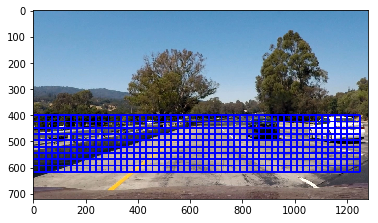

In [39]:
ystart = 400
ystop = 656
scale = 1.5
img = mpimg.imread(os.path.join('test_images', 'test1.jpg'))
out_img, windows = find_cars(img, ystart, ystop, scale)
plt.imshow(out_img)
print (len(windows))

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [20]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [21]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

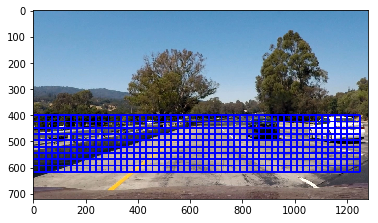

In [22]:
test_img = draw_boxes(img, windows)
plt.imshow(test_img)